# Movie success predictor using SVM
This code predict the success of the movie by classifying if it is
profitable or not.

* Fatima Falath | 1705727
* Tasneem Annahdi | 1705425
* Thekra ALamoudi | 1705839

**Note:** *this code has 3 parts*
1. Dataset : to fetch the data we will use
2. Data Exploration : To understand the data more
3. Data Classification : to classify the movies(Profitable/Not profitable)

In [ ]:
#import libraries
import pandas as pd
import numpy as np                          
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

## Clean the dataset

In [ ]:
#read and view the data
imdb_df = pd.read_csv("movie_dataset.csv", encoding = "ISO-8859-1")
print("The dataset shape:",imdb_df.shape)

The dataset shape: (1921, 20)


In [ ]:
#drop the movies when budget = 0
imdb_df = imdb_df[imdb_df.budget != 0]
#drop the movies that aren't made in USA
imdb_df = imdb_df[imdb_df.country == "USA"]
#drop the country column (we know it is USA)
imdb_df = imdb_df.drop(["country"], axis=1)
#drop the first column (no info needed)
imdb_df.drop(imdb_df.columns[0],axis=1,inplace=True)

In [ ]:
imdb_df.head(5)

,index,budget,company,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year,director_popularity,actor_popularity,writer_popularity
0,1,6000000,Paramount Pictures,John Hughes,Comedy,70136369,Ferris Bueller's Day Off,PG-13,6/11/1986,103,7.8,Matthew Broderick,264740,John Hughes,1986,0.600,2.336,2.665
1,2,15000000,Paramount Pictures,Tony Scott,Action,179800601,Top Gun,PG,5/16/1986,110,6.9,Tom Cruise,236909,Jim Cash,1986,2.489,22.915,1.960
2,3,18500000,Twentieth Century Fox Film Corporation,James Cameron,Action,85160248,Aliens,R,7/18/1986,137,8.4,Sigourney Weaver,540152,James Cameron,1986,4.903,7.124,0.600
3,4,9000000,Walt Disney Pictures,Randal Kleiser,Adventure,18564613,Flight of the Navigator,PG,8/1/1986,90,6.9,Joey Cramer,36636,Mark H. Baker,1986,0.631,0.838,0.600
4,8,9000000,Paramount Pictures,Howard Deutch,Comedy,40471663,Pretty in Pink,PG-13,2/28/1986,96,6.8,Molly Ringwald,60565,John Hughes,1986,1.400,2.965,2.665


# Data Exploration

### Revenue and Budget

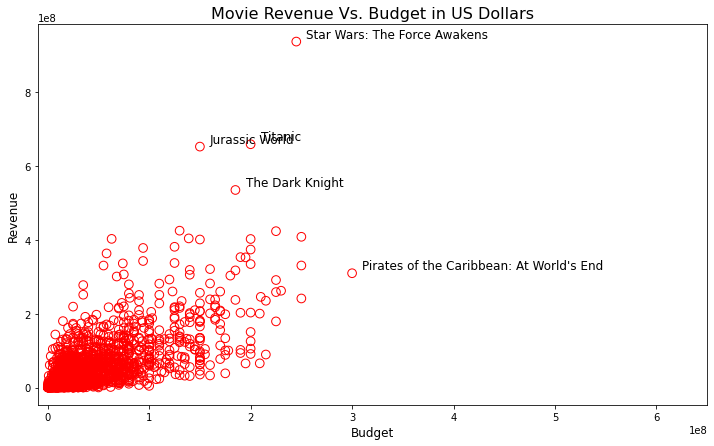

In [ ]:
annotations = imdb_df[(imdb_df["gross"] > 500000000) | \
                              (imdb_df["budget"] > 250000000)] 
annotations = annotations[["name", "budget", "gross"]].values

plt.figure(figsize=(12,7))
plt.scatter(imdb_df["budget"], imdb_df["gross"], marker="o", edgecolors='r', facecolors="none", 
            s=[75]*len(imdb_df["budget"]))
plt.xlabel("Budget", fontsize=12)
plt.xlim(-10000000, 650000000)
plt.ylabel("Revenue", fontsize=12)
plt.title("Movie Revenue Vs. Budget in US Dollars", fontsize=16)
for name, bud, rev in annotations:
    plt.annotate(name, xy=(bud+10000000, rev+10000000), fontsize=12)

plt.savefig("movie_predict" + "Budget_vs_Revenue.png")

The scatter plot shows the relationship between the budget and the revenue of each movie. We can see in the plot that in the left bottom there are a lot of movies that has low budget and low revenue. And movies that are in the right of the plot are movies that have a high budget, and at the top of the plot are movies that have high revenue. We can notice that there are a couple of movies that have the highest revenue such as: The Dark Knight, Jurassic World, Titanic, Star Wars: The Force Awakens. And a movie with the highest budget such as Pirates of the Caribbean: At World's End.

## Correlation between features

In [ ]:
#View the correlation between the quantative data
budget_revenue_corr = imdb_df.copy()
budget_revenue_corr = budget_revenue_corr[["budget", "gross", "director_popularity", "actor_popularity","writer_popularity"]].corr()
budget_revenue_corr

,budget,gross,director_popularity,actor_popularity,writer_popularity
budget,1.000000,0.668017,0.254786,0.321519,0.241135
gross,0.668017,1.000000,0.281951,0.249123,0.273805
director_popularity,0.254786,0.281951,1.000000,0.191075,0.206710
actor_popularity,0.321519,0.249123,0.191075,1.000000,0.095689
writer_popularity,0.241135,0.273805,0.206710,0.095689,1.000000


The table shows the strong relationship between the budget and gross, as the gross increases the budget increases too.

In [ ]:
#View the correlation between the quantative data
popularity_revenue_corr = imdb_df.copy()
popularity_revenue_corr = popularity_revenue_corr[["budget", "gross", "runtime", "score","votes"]].corr()
popularity_revenue_corr

,budget,gross,runtime,score,votes
budget,1.000000,0.668017,0.372403,0.142265,0.439094
gross,0.668017,1.000000,0.321368,0.299339,0.629287
runtime,0.372403,0.321368,1.000000,0.469532,0.431041
score,0.142265,0.299339,0.469532,1.000000,0.535611
votes,0.439094,0.629287,0.431041,0.535611,1.000000


In [ ]:
print("movies_dataset.shape :", imdb_df.shape)
plot_df = imdb_df.copy()

plot_df["year"] = plot_df["year"].astype(int).astype(str)
plot_df["profitability"] = (plot_df["gross"] -  plot_df["budget"]) / plot_df["budget"]
plot_df["release_date_month_no"] = pd.DatetimeIndex(plot_df["released"]).month
plot_df["release_date_month_str"] = pd.DatetimeIndex(plot_df["released"]).strftime("%b")
plot_df["release_date_year_month"] = pd.DatetimeIndex(plot_df["released"]).strftime("%Y-%b")
plot_df["release_date_year"] = pd.DatetimeIndex(plot_df["released"]).strftime("%Y")

plot_df.set_index("index", inplace=True)
plot_df.head()

movies_dataset.shape : (1921, 18)


,budget,company,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year,director_popularity,actor_popularity,writer_popularity,profitability,release_date_month_no,release_date_month_str,release_date_year_month,release_date_year
index,,,,,,,,,,,,,,,,,,,,,,
1,6000000,Paramount Pictures,John Hughes,Comedy,70136369,Ferris Bueller's Day Off,PG-13,6/11/1986,103,7.8,Matthew Broderick,264740,John Hughes,1986,0.600,2.336,2.665,10.689395,6,Jun,1986-Jun,1986
2,15000000,Paramount Pictures,Tony Scott,Action,179800601,Top Gun,PG,5/16/1986,110,6.9,Tom Cruise,236909,Jim Cash,1986,2.489,22.915,1.960,10.986707,5,May,1986-May,1986
3,18500000,Twentieth Century Fox Film Corporation,James Cameron,Action,85160248,Aliens,R,7/18/1986,137,8.4,Sigourney Weaver,540152,James Cameron,1986,4.903,7.124,0.600,3.603257,7,Jul,1986-Jul,1986
4,9000000,Walt Disney Pictures,Randal Kleiser,Adventure,18564613,Flight of the Navigator,PG,8/1/1986,90,6.9,Joey Cramer,36636,Mark H. Baker,1986,0.631,0.838,0.600,1.062735,8,Aug,1986-Aug,1986
8,9000000,Paramount Pictures,Howard Deutch,Comedy,40471663,Pretty in Pink,PG-13,2/28/1986,96,6.8,Molly Ringwald,60565,John Hughes,1986,1.400,2.965,2.665,3.496851,2,Feb,1986-Feb,1986


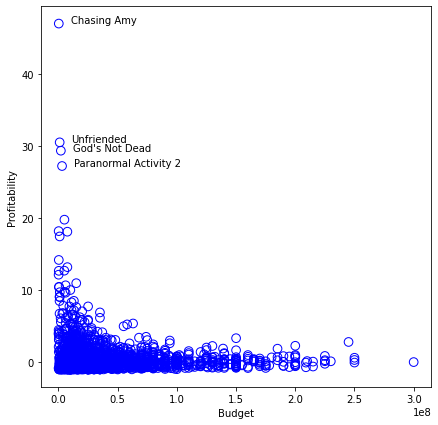

In [ ]:
plt.figure(figsize=(7,7))
plt.scatter(plot_df["budget"], plot_df["profitability"], marker="o", edgecolors="blue", facecolors="none", 
           s=[75]*len(plot_df["budget"]))
plt.ylabel("Profitability")
plt.xlabel("Budget")

annotations = plot_df[plot_df["profitability"] > 25]
annotations = annotations[["name", "budget", "profitability"]].values
for name, bud, prof in annotations:
    plt.annotate(name, xy=(bud+10000000, prof))

plt.savefig("Profitability_initial.png")

# annotations

The plot shows the budget and profitability of each movie. There are a couple of movies that had a low budget but got the highest profitability such as: paranormal activity 2, god's not dead, unfriended, chasing away. And also shows a movie that has the lowest profitability with a high budget.

In [ ]:
BUDGET_THRESHOLD = 1000000 
low_budget_values = plot_df[plot_df["budget"] <= BUDGET_THRESHOLD] \
                        .sort_values(["budget", "profitability"], ascending=[False, False])
print("low_budget_values.shape :", low_budget_values.shape)
low_budget_values.head()

low_budget_values.shape : (42, 22)


,budget,company,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year,director_popularity,actor_popularity,writer_popularity,profitability,release_date_month_no,release_date_month_str,release_date_year_month,release_date_year
index,,,,,,,,,,,,,,,,,,,,,,
6218,1000000,Bazelevs Production,Levan Gabriadze,Drama,31537320,Unfriended,R,4/17/2015,83,5.6,Heather Sossaman,52922,Nelson Greaves,2014,0.600,0.600,1.048,30.537320,4,Apr,2015-Apr,2015
5536,1000000,Snoot Entertainment,Adam Wingard,Horror,18474268,You're Next,R,8/23/2013,95,6.5,Sharni Vinson,70259,Simon Barrett,2011,1.050,1.020,0.600,17.474268,8,Aug,2013-Aug,2013
4337,1000000,Rogue Pictures,Jeff Wadlow,Drama,10047674,Cry_Wolf,PG-13,9/16/2005,90,5.9,Julian Morris,23845,Jeff Wadlow,2005,0.600,3.958,2.040,9.047674,9,Sep,2005-Sep,2005
2608,1000000,Lakeshore Entertainment,Scott Winant,Romance,3478370,'Til There Was You,PG-13,5/30/1997,113,4.8,Jeanne Tripplehorn,2415,Winnie Holzman,1997,0.600,4.179,0.980,2.478370,5,May,1997-May,1997
4353,1000000,Junebug Movie,Phil Morrison,Comedy,2678691,Junebug,R,9/16/2005,106,7.0,Embeth Davidtz,19828,Angus MacLachlan,2005,0.677,4.660,0.728,1.678691,9,Sep,2005-Sep,2005


In [ ]:
plot_df_clipped = plot_df.copy()
plot_df_clipped = plot_df_clipped[plot_df_clipped["budget"] > BUDGET_THRESHOLD]
plot_df_clipped.shape

(1879, 22)

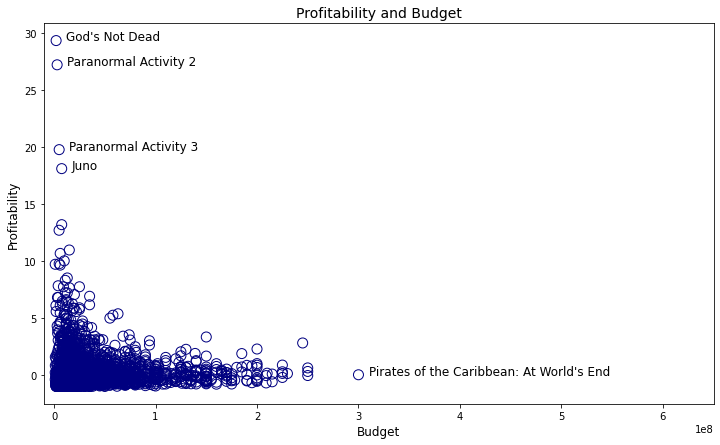

In [ ]:
plt.figure(figsize=(12,7))
plt.scatter(plot_df_clipped["budget"], 
            plot_df_clipped["profitability"], marker="o", edgecolors="navy", facecolors='none', 
           s=[100]*len(plot_df_clipped["budget"]))
plt.xlim(-10000000, 650000000)
plt.title("Profitability and Budget", fontsize=14)
plt.ylabel("Profitability", fontsize=12)
plt.xlabel("Budget", fontsize=12)

annotations = plot_df_clipped[(plot_df_clipped["profitability"] > 15) | \
                              (plot_df_clipped["budget"] > 250000000)]
annotations = annotations[["name", "budget", "profitability"]].values
for name, bud, prof in annotations:
    plt.annotate(name, xy=(bud+10000000, prof), fontsize=12)
    
plt.savefig( "Profitability_clipped.png")

The plot shows the profitability and budget of movies that are higher than the threshold. In the bottom left of the plot, some movies have a low budget with low profitability. And we can notice in the top left there are movies that have the highest profitability with low budget with, and are: Juno, paranormal activity 3, paranormal activity 2, god's not dead. And the movie: Pirates of the Caribbean: at the world's end, has the highest budget with low profitability.  



count    1921.000000
mean        0.646938
std         2.452691
min        -0.999822
25%        -0.496858
50%         0.050359
75%         0.928119
max        47.026056
Name: profitability, dtype: float64

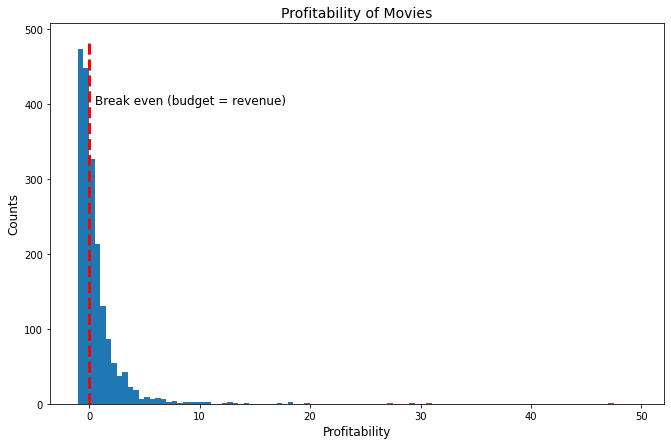

In [ ]:
plt.figure(figsize=(11,7))
bins = np.arange(-1.0, 50.0, 0.5)
plt.hist(plot_df["profitability"], bins=bins)
plt.title("Profitability of Movies", fontsize=14)
plt.vlines(0.0, 0.0, 483, linestyle="--", color='r', linewidth=3)
plt.text(0.5, 400.0, "Break even (budget = revenue)", fontsize=12)
plt.ylabel("Counts", fontsize=12)
plt.xlabel("Profitability", fontsize=12)
# plt.savefig(save_dir + "/Profitability_initial.png")

plot_df["profitability"].describe()

The plot shows the count of the profitability movies. The red line indicates movies that has a profitabilty equals the movie budget,
left to the red line is movies have that has profitabilty lower than the movie budget, while the right of the line is movies that has a 
profitabilty higher than the movie's budget.

Text(0.5, 0, 'Profitability')

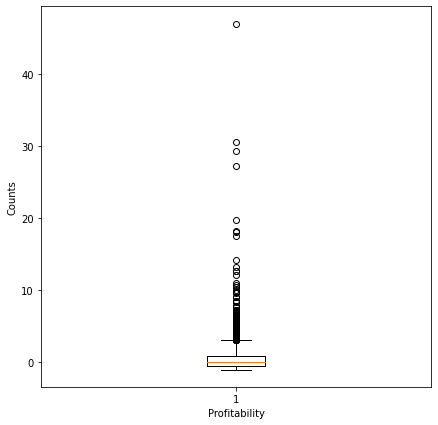

In [ ]:
plt.figure(figsize=(7,7))
plt.boxplot(plot_df["profitability"])
plt.ylabel("Counts")
plt.xlabel("Profitability")

Text(0.5, 0, 'Profitability')

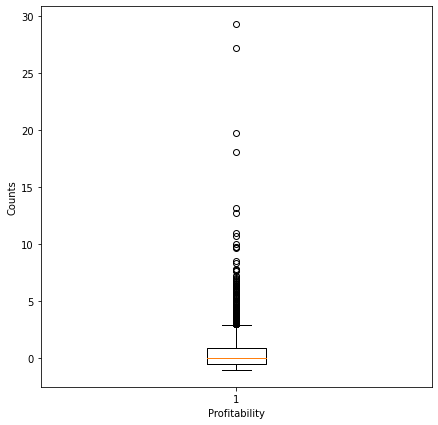

In [ ]:
plt.figure(figsize=(7,7))
plt.boxplot(plot_df_clipped["profitability"])
plt.ylabel("Counts")
plt.xlabel("Profitability")

The plot shows the effect of increasing the threshold budget value. So, when the profitability increases the data point separation is much easier to read.

In [ ]:
plot_time_df_1 = plot_df.copy()
plot_time_df_1 = plot_time_df_1.groupby(["release_date_year"])["budget", "gross"].sum().reset_index()
plot_time_df_1["number_movies"] = plot_time_df_1["release_date_year"].map(plot_df["release_date_year"].value_counts())
plot_time_df_1["profitability"] = (plot_time_df_1["gross"] - plot_time_df_1["budget"]) / plot_time_df_1["budget"]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [ ]:
plot_time_df_1.head()

,release_date_year,budget,gross,number_movies,profitability
0,1986,553500000,1022234583,40,0.846856
1,1987,533225000,1049147182,38,0.967551
2,1988,754900000,1593155135,46,1.110419
3,1989,895900000,1934384388,50,1.159152
4,1990,865111000,1458707684,39,0.686151


No handles with labels found to put in legend.


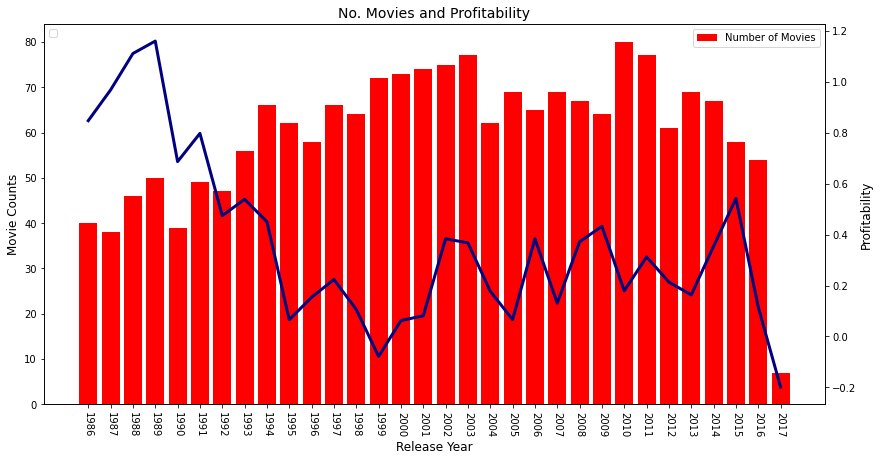

In [ ]:
# plt.figure(figsize=(14,7))
fig, ax1 = plt.subplots(figsize=(14,7))
ax1.bar(plot_time_df_1["release_date_year"], plot_time_df_1["number_movies"], 
        label="Number of Movies", color='r')

ax2 = ax1.twinx()
ax2.plot(plot_time_df_1["release_date_year"], plot_time_df_1["profitability"],
         linewidth=3.0, color="navy")

ax1.set_title("No. Movies and Profitability", fontsize=14)
ax1.set_ylabel("Movie Counts", fontsize=12)
ax2.set_ylabel("Profitability", fontsize=12)
ax1.set_xticklabels(plot_time_df_1["release_date_year"], rotation=-90)
ax1.set_xlabel("Release Year", fontsize=12)
ax1.legend(loc=1)
ax2.legend(loc=2)

The plot shows the number of movies in each year along with the number of profitable movies in each year. 

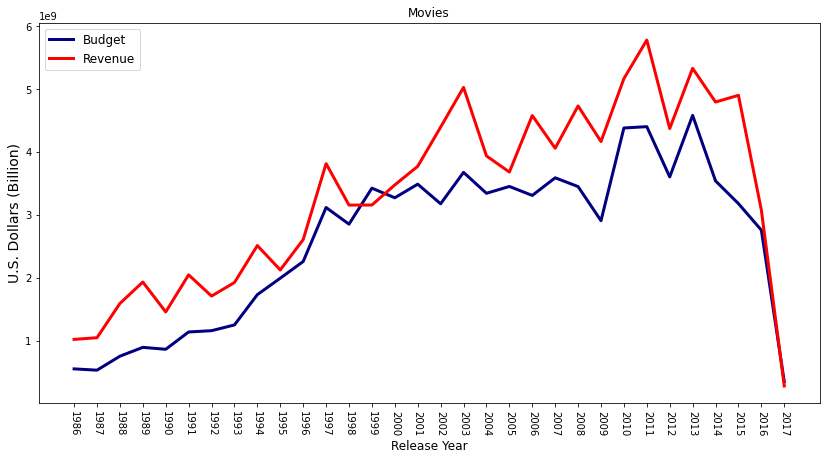

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(plot_time_df_1["release_date_year"], plot_time_df_1["budget"],
         linewidth=3.0, color="navy", label="Budget")
plt.plot(plot_time_df_1["release_date_year"], plot_time_df_1["gross"],
         linewidth=3.0, color='r', label="Revenue")
plt.title("Movies", fontsize=12)
plt.ylabel("U.S. Dollars (Billion)", fontsize=14)
plt.xticks(rotation=-90)
plt.xlabel("Release Year", fontsize=12)
plt.legend(loc=2, fontsize=12)

The plot shows the revenue and budget of the movies through the year, and we notice an abnorman behaviour in the year of 2017.
To know more about the reason behind it we will look closely into the movies that was released in the year of 2017.

In [ ]:
plot_df[plot_df["release_date_year"]=="2017"]

,budget,company,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year,director_popularity,actor_popularity,writer_popularity,profitability,release_date_month_no,release_date_month_str,release_date_year_month,release_date_year
index,,,,,,,,,,,,,,,,,,,,,,
6609,30000000,Keep Your Head,James Gray,Adventure,8574339,The Lost City of Z,PG-13,4/21/2017,141,6.6,Charlie Hunnam,39409,James Gray,2016,0.600,4.995,0.788,-0.714189,4,Apr,2017-Apr,2017
6611,25000000,Levantine Films,Theodore Melfi,Biography,169380936,Hidden Figures,PG,1/6/2017,127,7.8,Taraji P. Henson,121818,Allison Schroeder,2016,1.751,2.576,1.400,5.775237,1,Jan,2017-Jan,2017
6638,46000000,Cappa Defina Productions,Martin Scorsese,Adventure,7079191,Silence,R,1/13/2017,161,7.2,Andrew Garfield,61798,Jay Cocks,2016,5.362,5.016,1.344,-0.846105,1,Jan,2017-Jan,2017
6641,25000000,FilmNation Entertainment,John Lee Hancock,Biography,12785093,The Founder,PG-13,1/20/2017,100,7.2,Michael Keaton,62193,Robert D. Siegel,2016,0.607,9.238,0.840,-0.488596,1,Jan,2017-Jan,2017
6643,35000000,Lakeshore Entertainment,Anna Foerster,Action,30348260,Underworld: Blood Wars,R,1/6/2017,91,5.8,Kate Beckinsale,49911,Cory Goodman,2016,1.400,10.164,0.600,-0.132907,1,Jan,2017-Jan,2017
6652,40000000,Regency Enterprises,Gore Verbinski,Drama,8106986,A Cure for Wellness,R,2/17/2017,146,6.4,Dane DeHaan,45187,Justin Haythe,2016,3.384,5.090,1.400,-0.797325,2,Feb,2017-Feb,2017
6653,150000000,Legendary East,Yimou Zhang,Action,45157105,The Great Wall,PG-13,2/17/2017,103,6.0,Matt Damon,82181,Carlo Bernard,2016,1.513,9.770,1.380,-0.698953,2,Feb,2017-Feb,2017


The table shows the movies that were released in the year 2017. The table shows only a few movies that were released in the bigging of the year, which explains why in the plot there was a very low budget and profitability of the year of 2017 because the dataset only had a few movies that was released in the year of 2017. 